In [48]:
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import torch.nn.functional as F
import librosa
import numpy as np
from torchvision import models
import os
import soundfile as sf

import matplotlib.pyplot as plt

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [76]:
import numpy as np
import librosa

y, sr = librosa.load('kangaroo.wav', duration=10)
S = np.abs(librosa.stft(y))
y_inv = librosa.griffinlim(S)

In [84]:
def audio_to_spectrogram(audio_path, sr=22050, n_fft=2048, hop_length=512,duration=10):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr,duration=duration)
    
    # Compute the Short-Time Fourier Transform (STFT)
    spectrogram = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    
    # Convert to magnitude spectrogram (absolute value)
    magnitude = np.abs(spectrogram)
    
    # Convert to log scale for better visualization
    log_magnitude = librosa.amplitude_to_db(magnitude, ref=np.max)
    
    # Return the spectrogram as a PyTorch tensor
    return torch.tensor(log_magnitude).to(device), y, sr  # Return magnitude too

In [85]:
def plot_spectrogram(log_magnitude, sr, hop_length):
    # Create a matplotlib plot for the spectrogram
    plt.figure(figsize=(10, 6))
    
    # Display the log-magnitude spectrogram
    librosa.display.specshow(log_magnitude, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    
    # Add color bar and labels
    plt.colorbar(format="%+2.0f dB")
    plt.title("Log-Scaled Spectrogram")
    plt.tight_layout()
    plt.show()

In [98]:
def spectrogram_to_audio(y):
    audio = np.abs(librosa.stft(y))
    y_inv = librosa.griffinlim(audio)
    return audio

In [99]:
log, y, sr = audio_to_spectrogram('kangaroo.wav')

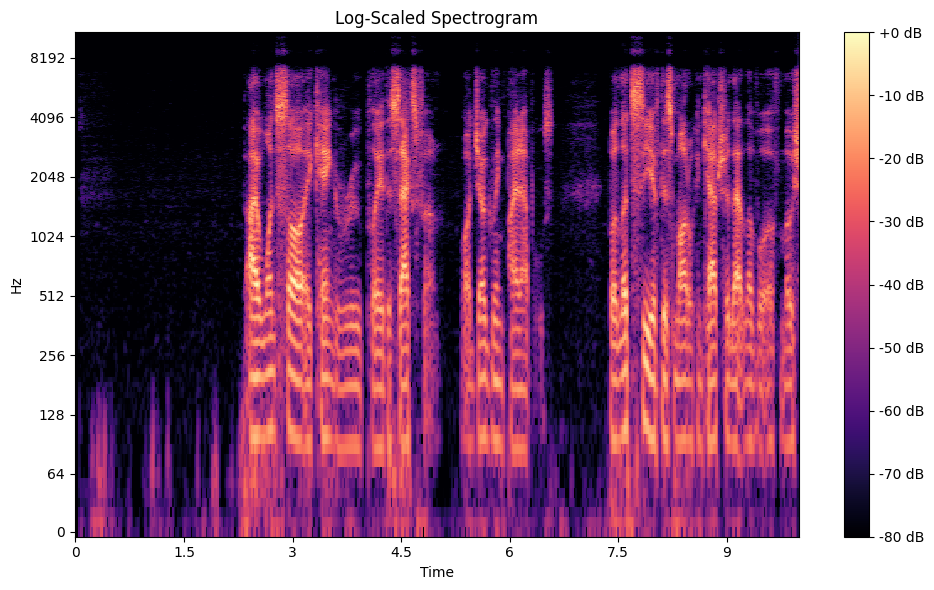

In [100]:
plot_spectrogram(log.cpu().numpy(), sr, hop_length=512)

In [101]:
def save_audio_as_wav(audio, sr=22050, filename='output.wav'):
    sf.write(filename, audio, sr)
    print("Audio Saved")

In [103]:
rev = spectrogram_to_audio(y)

In [104]:
save_audio_as_wav(y_inv, sr=sr, filename='output.wav')

Audio Saved


In [31]:
def GramMatrix(input):
    # A = batch
    # B = Number of feature maps
    # C,D = Dimension of feature maps
    a,b,c,d = input.size()

    features = input.view(a*b,c*d)

    G = torch.mm(features, features.t())

    #Normalize by dividing by total
    return G.div(a*b*c*d)

In [32]:
vgg = models.vgg19(pretrained=True).features.to(device)

c:\Users\xkhai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\xkhai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
class CNNMODEL(nn.Module):
    def __init__(self):
        super(CNNMODEL, self).__init__()
        # Load pre-trained VGG19 and extract the 'features' part (excluding the classifier)
        self.vgg = models.vgg19(pretrained=True).features
        
        # Freeze the VGG19 model weights (no need for backpropagation)
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Forward pass through the VGG19 feature extractor
        return self.vgg(x)

In [38]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        # Detach target and apply weight scaling
        self.target = self.gram(target).detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # Compute the Gram matrix of the input
        G = self.gram(x)
        
        # Scale by weight
        G = G * self.weight
        
        # Compute the loss
        self.loss = self.criterion(G, self.target)
        
        return x

In [40]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # Detach target to avoid backprop through it
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # Compute content loss between input and target features
        self.loss = self.criterion(x, self.target)
        return x